In [1]:
import sys
import os

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sys.path.insert(0, os.path.abspath('..'))

from src.factories import ModelFactory
from src.utils.load_cfg import ConfigLoader
from tools.complexity import (get_model_complexity_info,
                              is_supported_instance,
                              flops_to_string,
                              get_model_parameters_number)

In [2]:
def collect_flops(model, units='GMac', precision=3):
    """Wrapper to collect flops and number of parameters at each layer"""
    total_flops = model.compute_average_flops_cost()

    def accumulate_flops(self):
        if is_supported_instance(self):
            return self.__flops__ / model.__batch_counter__
        else:
            sum = 0
            for m in self.children():
                sum += m.accumulate_flops()
            return sum

    def flops_repr(self):
        accumulated_flops_cost = self.accumulate_flops()
        return ', '.join([flops_to_string(accumulated_flops_cost, units=units, precision=precision),
                          '{:.3%} MACs'.format(accumulated_flops_cost / total_flops),
                          self.original_extra_repr()])

    def add_extra_repr(m):
        m.accumulate_flops = accumulate_flops.__get__(m)
        flops_extra_repr = flops_repr.__get__(m)
        if m.extra_repr != flops_extra_repr:
            m.original_extra_repr = m.extra_repr
            m.extra_repr = flops_extra_repr
            assert m.extra_repr != m.original_extra_repr

    def del_extra_repr(m):
        if hasattr(m, 'original_extra_repr'):
            m.extra_repr = m.original_extra_repr
            del m.original_extra_repr
        if hasattr(m, 'accumulate_flops'):
            del m.accumulate_flops

    model.apply(add_extra_repr)
    # print(model, file=ost)

    # Retrieve flops and param at each layer and sub layer (2 levels)
    flops_dict, param_dict = {}, {}
    for i in model._modules.keys():
        item = model._modules[i]
        if isinstance(model._modules[i], torch.nn.modules.container.Sequential):
            for j in model._modules[i]._modules.keys():
                key = '{}-{}'.format(i, j)
                flops_dict[key] = item._modules[j].accumulate_flops()
                param_dict[key] = get_model_parameters_number(item._modules[j])
        else:
            flops_dict[i] = item.accumulate_flops()
            param_dict[i] = get_model_parameters_number(item)

    model.apply(del_extra_repr)
    return flops_dict, param_dict


def run_experiment_flops(model, in_size, verbose=True, as_strings=True):
    macs, params = get_model_complexity_info(model, in_size, as_strings=as_strings, print_per_layer_stat=False)
    print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
    print('{:<30}  {:<8}'.format('Number of parameters: ', params))
    print()

    if verbose:
        print('{:<15} {:>12} {:>12} {:>12} {:>12}'.format(
            'Layer', 'Flops (GMac)', 'Param (M)', 'AccFlops', 'AccParam'))
        print('-'*67)
        flops_dict, param_dict = collect_flops(model)
        total_flops, total_param = 0, 0
        for k in flops_dict:
            total_flops += flops_dict[k]*1e-9
            total_param += param_dict[k]*1e-6
            print('{:<15} {:>12.5f} {:>12.5f} {:>12.2f} {:>12.2f}'.format(
                k, flops_dict[k]*1e-9, param_dict[k]*1e-6, total_flops, total_param))
    return macs

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_factory = ModelFactory()

# TBN - ['RGB', 'Spec', 'Flow']

In [4]:
model_cfg = '../configs/model_cfgs/tbn.yaml'
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)

model_params.update({
    'num_segments': 1,
})
model = model_factory.generate(model_name, device=device, **model_params)

rgb_flops, rgb_params = get_model_complexity_info(
    model.rgb, (3, 224, 224), as_strings=False, print_per_layer_stat=False)
spec_flops, spec_params = get_model_complexity_info(
    model.spec, (1, 256, 256), as_strings=False, print_per_layer_stat=False)
flow_flops, flow_params = get_model_complexity_info(
    model.flow, (5*2, 224, 224), as_strings=False, print_per_layer_stat=False)

fc1_flops, fc1_params = get_model_complexity_info(
    model.fusion_classification_net.fc1, (1, 3*1024), as_strings=False, print_per_layer_stat=False)
relu_flops, relu_params = get_model_complexity_info(
    model.fusion_classification_net.relu, (1, 512), as_strings=False, print_per_layer_stat=False)
fc_verb_flops, fc_verb_params = get_model_complexity_info(
    model.fusion_classification_net.fc_verb, (1, 512), as_strings=False, print_per_layer_stat=False)
fc_noun_flops, fc_noun_params = get_model_complexity_info(
    model.fusion_classification_net.fc_noun, (1, 512), as_strings=False, print_per_layer_stat=False)

tbn_flops = rgb_flops + spec_flops + flow_flops + \
            fc1_flops + relu_flops + fc_verb_flops + fc_noun_flops
tbn_params = rgb_params + spec_params + flow_params + \
             fc1_params + relu_params + fc_verb_params + fc_noun_params

print('RGB')
print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
    rgb_flops*1e-9, rgb_params*1e-6))

print('Spec')
print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
    spec_flops*1e-9, spec_params*1e-6))

print('Flow')
print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
    flow_flops*1e-9, flow_params*1e-6))

print('Total')
print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
    tbn_flops*1e-9, tbn_params*1e-6))

RGB
 flops: 2.05*1e9, params: 10.27*1e6
Spec
 flops: 2.57*1e9, params: 10.26*1e6
Flow
 flops: 2.32*1e9, params: 10.29*1e6
Total
 flops: 6.95*1e9, params: 32.64*1e6


# TBN - ['RGB', 'Spec']

In [5]:
model_cfg = '../configs/model_cfgs/tbn.yaml'
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)

model_params.update({
    'num_segments': 1,
    'modality': ['RGB', 'Spec']
})
model = model_factory.generate(model_name, device=device, **model_params)

rgb_flops, rgb_params = get_model_complexity_info(
    model.rgb, (3, 224, 224), as_strings=False, print_per_layer_stat=False)
spec_flops, spec_params = get_model_complexity_info(
    model.spec, (1, 256, 256), as_strings=False, print_per_layer_stat=False)

fc1_flops, fc1_params = get_model_complexity_info(
    model.fusion_classification_net.fc1, (1, 2*1024), as_strings=False, print_per_layer_stat=False)
relu_flops, relu_params = get_model_complexity_info(
    model.fusion_classification_net.relu, (1, 512), as_strings=False, print_per_layer_stat=False)
fc_verb_flops, fc_verb_params = get_model_complexity_info(
    model.fusion_classification_net.fc_verb, (1, 512), as_strings=False, print_per_layer_stat=False)
fc_noun_flops, fc_noun_params = get_model_complexity_info(
    model.fusion_classification_net.fc_noun, (1, 512), as_strings=False, print_per_layer_stat=False)

tbn_flops = rgb_flops + spec_flops + \
            fc1_flops + relu_flops + fc_verb_flops + fc_noun_flops
tbn_params = rgb_params + spec_params + \
             fc1_params + relu_params + fc_verb_params + fc_noun_params

print('RGB')
print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
    rgb_flops*1e-9, rgb_params*1e-6))

print('Spec')
print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
    spec_flops*1e-9, spec_params*1e-6))

print('Total')
print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
    tbn_flops*1e-9, tbn_params*1e-6))

RGB
 flops: 2.05*1e9, params: 10.27*1e6
Spec
 flops: 2.57*1e9, params: 10.26*1e6
Total
 flops: 4.62*1e9, params: 21.83*1e6


# SAN19 feat - 224

In [6]:
model_cfg = '../configs/model_cfgs/pipeline_simple_san19pair_rgbspec.yaml'
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)

model_params.update({
    'num_segments': 1,
    'modality': ['RGB', 'Spec']
})
model = model_factory.generate(model_name, model_factory=model_factory, device=device, **model_params)
model.to(device)

# print(model.light_model)

rgb_flops, rgb_params = get_model_complexity_info(
    model.light_model.rgb, (3, 224, 224), as_strings=False, print_per_layer_stat=False)
spec_flops, spec_params = get_model_complexity_info(
    model.light_model.spec, (1, 256, 256), as_strings=False, print_per_layer_stat=False)

fc1_flops, fc1_params = get_model_complexity_info(
    model.actreg_model.fc1, (1, 2*2048), as_strings=False, print_per_layer_stat=False)
relu_flops, relu_params = get_model_complexity_info(
    model.actreg_model.relu, (1, 512), as_strings=False, print_per_layer_stat=False)
fc_verb_flops, fc_verb_params = get_model_complexity_info(
    model.actreg_model.fc_verb, (1, 512), as_strings=False, print_per_layer_stat=False)
fc_noun_flops, fc_noun_params = get_model_complexity_info(
    model.actreg_model.fc_noun, (1, 512), as_strings=False, print_per_layer_stat=False)

tbn_flops = rgb_flops + spec_flops + \
            fc1_flops + relu_flops + fc_verb_flops + fc_noun_flops
tbn_params = rgb_params + spec_params + \
             fc1_params + relu_params + fc_verb_params + fc_noun_params

print('RGB')
print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
    rgb_flops*1e-9, rgb_params*1e-6))

print('Spec')
print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
    spec_flops*1e-9, spec_params*1e-6))

print('Total')
print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
    tbn_flops*1e-9, tbn_params*1e-6))

RGB
 flops: 3.84*1e9, params: 15.55*1e6
Spec
 flops: 5.01*1e9, params: 15.55*1e6
Total
 flops: 8.85*1e9, params: 33.44*1e6


# SAN19 feat - 112

In [7]:
model_cfg = '../configs/model_cfgs/pipeline_simple_san19pair_rgbspec_112.yaml'
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)

model_params.update({
    'num_segments': 1,
    'modality': ['RGB', 'Spec']
})
model = model_factory.generate(model_name, model_factory=model_factory, device=device, **model_params)
model.to(device)

# print(model.light_model)

rgb_flops, rgb_params = get_model_complexity_info(
    model.light_model.rgb, (3, 112, 112), as_strings=False, print_per_layer_stat=False)
spec_flops, spec_params = get_model_complexity_info(
    model.light_model.spec, (1, 256, 256), as_strings=False, print_per_layer_stat=False)

fc1_flops, fc1_params = get_model_complexity_info(
    model.actreg_model.fc1, (1, 2*2048), as_strings=False, print_per_layer_stat=False)
relu_flops, relu_params = get_model_complexity_info(
    model.actreg_model.relu, (1, 512), as_strings=False, print_per_layer_stat=False)
fc_verb_flops, fc_verb_params = get_model_complexity_info(
    model.actreg_model.fc_verb, (1, 512), as_strings=False, print_per_layer_stat=False)
fc_noun_flops, fc_noun_params = get_model_complexity_info(
    model.actreg_model.fc_noun, (1, 512), as_strings=False, print_per_layer_stat=False)

tbn_flops = rgb_flops + spec_flops + \
            fc1_flops + relu_flops + fc_verb_flops + fc_noun_flops
tbn_params = rgb_params + spec_params + \
             fc1_params + relu_params + fc_verb_params + fc_noun_params

print('RGB')
print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
    rgb_flops*1e-9, rgb_params*1e-6))

print('Spec')
print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
    spec_flops*1e-9, spec_params*1e-6))

print('Total')
print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
    tbn_flops*1e-9, tbn_params*1e-6))

RGB
 flops: 0.92*1e9, params: 15.55*1e6
Spec
 flops: 5.01*1e9, params: 15.55*1e6
Total
 flops: 5.93*1e9, params: 33.44*1e6


# Pipeline6

In [8]:
def check_pipeline6(model_cfg, top_k, combine='cat'):
    model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
    model_params['hallu_pretrained_weights'] = '../' + model_params['hallu_pretrained_weights']
    model_params['actreg_pretrained_weights'] = '../' + model_params['actreg_pretrained_weights']
    model = model_factory.generate(model_name, device=device,
                                   model_factory=model_factory, **model_params)
    
    # ------------------------------------------------------------------------------------------
    # RGB 112
    print('RGB 112')
    rgb_112_flops, rgb_112_params = get_model_complexity_info(
        model.low_feat_model.rgb, (3, 112, 112), as_strings=False, print_per_layer_stat=False)
    flops_dict, param_dict = collect_flops(model.low_feat_model.rgb)

    rgb_112_first_flops, rgb_112_first_params = 0, 0
    for k in flops_dict:
        rgb_112_first_flops += flops_dict[k]
        rgb_112_first_params += param_dict[k]
        if k == 'layer3-0':
            break
    rgb_112_second_flops = rgb_112_flops - rgb_112_first_flops
    rgb_112_second_params = rgb_112_params - rgb_112_first_params
    print(' flops: {}, params: {}'.format(rgb_112_flops, rgb_112_params))
    print(' 1st half - flops: {}, params: {}'.format(rgb_112_first_flops, rgb_112_first_params))
    print(' 2nd half - flops: {}, params: {}'.format(rgb_112_second_flops, rgb_112_second_params))

    # ------------------------------------------------------------------------------------------
    # RGB 64
    print('RGB 64')
    rgb_64_flops, rgb_64_params = get_model_complexity_info(
        model.high_feat_model.rgb, (3, 64, 64), as_strings=False, print_per_layer_stat=False)
    print(' flops: {}, params: {}'.format(rgb_64_flops, rgb_64_params))

    # ------------------------------------------------------------------------------------------
    # Spec
    print('Spec')
    spec_flops, spec_params = get_model_complexity_info(
        model.low_feat_model.spec, (1, 256, 256), as_strings=False, print_per_layer_stat=False)
    print(' flops: {}, params: {}'.format(spec_flops, spec_params))

    # ------------------------------------------------------------------------------------------
    # Hallucination
    print('Hallucination')
    hallu_flops, hallu_params = get_model_complexity_info(
        model.hallu_model, (1, 32, 7, 7), as_strings=False, print_per_layer_stat=False)
    print(' flops: {}, params: {}'.format(hallu_flops, hallu_params))

    # ------------------------------------------------------------------------------------------
    # Actreg
    print('ActionRecognition')
    if combine == 'cat':
        dim = 2048*2 + 2048*top_k
    elif combine == 'add':
        dim = 2048
    actreg_flops, actreg_params = get_model_complexity_info(
        model.actreg_model, (1, dim), as_strings=False, print_per_layer_stat=False)
    print(' flops: {}, params: {}'.format(actreg_flops, actreg_params))

    # ------------------------------------------------------------------------------------------
    # Unskipped
    print('-'*80)
    print('Unskipped frame')
    unskipped_flops = rgb_112_first_flops + hallu_flops + \
                      rgb_112_second_flops + \
                      rgb_64_flops * top_k + \
                      spec_flops + \
                      actreg_flops
    unskipped_params = rgb_112_first_params + hallu_params + \
                       rgb_112_second_params + \
                       rgb_64_params * (top_k != 0) + \
                       spec_params + \
                       actreg_params
    print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
        unskipped_flops*1e-9, unskipped_params*1e-6))

    # ------------------------------------------------------------------------------------------
    # Skipped
    print('Skipped frame')
    skipped_flops = rgb_112_first_flops + hallu_flops
    skipped_params = rgb_112_first_params + hallu_params
    print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
        skipped_flops*1e-9, skipped_params*1e-6))
    print(' skipped/unskipped percentage - flops: {:.02f}%, params: {:.02f}%'.format(
        skipped_flops/unskipped_flops*100,
        skipped_params/unskipped_params*100))

In [9]:
top_k = 0
model_cfg = '../configs/model_cfgs/pipeline6_rgbspec_san19pairfreeze_halluconv2_actreggru2_top0_cat.yaml'

check_pipeline6(model_cfg, top_k)

RGB 112
 flops: 915451790.0, params: 15547156
 1st half - flops: 541843470.0, params: 2152036
 2nd half - flops: 373608320.0, params: 13395120
RGB 64
 flops: 313641192.0, params: 15547156
Spec
 flops: 5009870464.0, params: 15547028
Hallucination
 flops: 4536224.0, params: 92480
ActionRecognition
 flops: 1580547.0, params: 3918301
--------------------------------------------------------------------------------
Unskipped frame
 flops: 5.93*1e9, params: 35.10*1e6
Skipped frame
 flops: 0.55*1e9, params: 2.24*1e6
 skipped/unskipped percentage - flops: 9.21%, params: 6.39%


In [10]:
top_k = 1
model_cfg = '../configs/model_cfgs/pipeline6_rgbspec_san19pairfreeze_halluconv2_actreggru2_top1_cat.yaml'

check_pipeline6(model_cfg, top_k)

RGB 112
 flops: 915451790.0, params: 15547156
 1st half - flops: 541843470.0, params: 2152036
 2nd half - flops: 373608320.0, params: 13395120
RGB 64
 flops: 313641192.0, params: 15547156
Spec
 flops: 5009870464.0, params: 15547028
Hallucination
 flops: 4536224.0, params: 92480
ActionRecognition
 flops: 1580547.0, params: 4966877
--------------------------------------------------------------------------------
Unskipped frame
 flops: 6.25*1e9, params: 51.70*1e6
Skipped frame
 flops: 0.55*1e9, params: 2.24*1e6
 skipped/unskipped percentage - flops: 8.75%, params: 4.34%


In [11]:
top_k = 2
model_cfg = '../configs/model_cfgs/pipeline6_rgbspec_san19pairfreeze_halluconv2_actreggru2_top2_cat.yaml'

check_pipeline6(model_cfg, top_k)

RGB 112
 flops: 915451790.0, params: 15547156
 1st half - flops: 541843470.0, params: 2152036
 2nd half - flops: 373608320.0, params: 13395120
RGB 64
 flops: 313641192.0, params: 15547156
Spec
 flops: 5009870464.0, params: 15547028
Hallucination
 flops: 4536224.0, params: 92480
ActionRecognition
 flops: 1580547.0, params: 6015453
--------------------------------------------------------------------------------
Unskipped frame
 flops: 6.56*1e9, params: 52.75*1e6
Skipped frame
 flops: 0.55*1e9, params: 2.24*1e6
 skipped/unskipped percentage - flops: 8.33%, params: 4.26%


In [12]:
top_k = 3
model_cfg = '../configs/model_cfgs/pipeline6_rgbspec_san19pairfreeze_halluconv2_actreggru2_top3_cat.yaml'

check_pipeline6(model_cfg, top_k)

RGB 112
 flops: 915451790.0, params: 15547156
 1st half - flops: 541843470.0, params: 2152036
 2nd half - flops: 373608320.0, params: 13395120
RGB 64
 flops: 313641192.0, params: 15547156
Spec
 flops: 5009870464.0, params: 15547028
Hallucination
 flops: 4536224.0, params: 92480
ActionRecognition
 flops: 1580547.0, params: 7064029
--------------------------------------------------------------------------------
Unskipped frame
 flops: 6.87*1e9, params: 53.80*1e6
Skipped frame
 flops: 0.55*1e9, params: 2.24*1e6
 skipped/unskipped percentage - flops: 7.95%, params: 4.17%


# Pipeline5

In [13]:
def check_pipeline5(model_cfg, top_k, combine='cat'):
    model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
    model = model_factory.generate(model_name, device=device,
                                   model_factory=model_factory, **model_params)
    model.to(device)

    # ------------------------------------------------------------------------------------------
    # RGB 112
    print('RGB 112')
    rgb_112_flops, rgb_112_params = get_model_complexity_info(
        model.high_feat_model.rgb, (3, 112, 112), as_strings=False, print_per_layer_stat=False)
    print(' flops: {}, params: {}'.format(rgb_112_flops, rgb_112_params))

    # ------------------------------------------------------------------------------------------
    # RGB 64
    print('RGB 64')
    rgb_64_flops, rgb_64_params = get_model_complexity_info(
        model.high_feat_model.rgb, (3, 64, 64), as_strings=False, print_per_layer_stat=False)
    print(' flops: {}, params: {}'.format(rgb_64_flops, rgb_64_params))

    # ------------------------------------------------------------------------------------------
    # Spec
    print('Spec')
    spec_flops, spec_params = get_model_complexity_info(
        model.low_feat_model.spec, (1, 256, 256), as_strings=False, print_per_layer_stat=False)
    print(' flops: {}, params: {}'.format(spec_flops, spec_params))

    # ------------------------------------------------------------------------------------------
    # Actreg
    print('ActionRecognition')
    if combine == 'cat':
        dim = 2048*2 + 2048*top_k
    elif combine == 'add':
        dim = 2048
    actreg_flops, actreg_params = get_model_complexity_info(
        model.actreg_model, (1, dim), as_strings=False, print_per_layer_stat=False)
    print(' flops: {}, params: {}'.format(actreg_flops, actreg_params))

    # ------------------------------------------------------------------------------------------
    # Total
    print('-'*80)
    print('Total')
    total_flops = rgb_112_flops + rgb_64_flops*top_k + spec_flops + actreg_flops
    total_params = rgb_112_params + rgb_64_params + spec_params + actreg_params
    print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
        total_flops*1e-9, total_params*1e-6))

In [14]:
top_k = 1
model_cfg = '../configs/model_cfgs/pipeline5_rgbspec_san19pairfreeze_actreggru2_top1_cat.yaml'

check_pipeline5(model_cfg, top_k)

RGB 112
 flops: 915451790.0, params: 15547156
RGB 64
 flops: 313641192.0, params: 15547156
Spec
 flops: 5009870464.0, params: 15547028
ActionRecognition
 flops: 1580547.0, params: 4966877
--------------------------------------------------------------------------------
Total
 flops: 6.24*1e9, params: 51.61*1e6


In [15]:
top_k = 2
model_cfg = '../configs/model_cfgs/pipeline5_rgbspec_san19pairfreeze_actreggru2_top2_cat.yaml'

check_pipeline5(model_cfg, top_k)

RGB 112
 flops: 915451790.0, params: 15547156
RGB 64
 flops: 313641192.0, params: 15547156
Spec
 flops: 5009870464.0, params: 15547028
ActionRecognition
 flops: 1580547.0, params: 6015453
--------------------------------------------------------------------------------
Total
 flops: 6.55*1e9, params: 52.66*1e6


In [16]:
top_k = 3
model_cfg = '../configs/model_cfgs/pipeline5_rgbspec_san19pairfreeze_actreggru2_top3_cat.yaml'

check_pipeline5(model_cfg, top_k)

RGB 112
 flops: 915451790.0, params: 15547156
RGB 64
 flops: 313641192.0, params: 15547156
Spec
 flops: 5009870464.0, params: 15547028
ActionRecognition
 flops: 1580547.0, params: 7064029
--------------------------------------------------------------------------------
Total
 flops: 6.87*1e9, params: 53.71*1e6


# Pipeline4 - 112-cat

In [17]:
model_cfg = '../configs/model_cfgs/pipeline4_rgbspec_san19pairfreeze112_actreggru2.yaml'
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
model = model_factory.generate(model_name, device=device,
                               model_factory=model_factory, **model_params)
model.to(device)

# ------------------------------------------------------------------------------------------
# RGB
print('RGB')
rgb_flops, rgb_params = get_model_complexity_info(
    model.feat_model.rgb, (3, 112, 112), as_strings=False, print_per_layer_stat=False)
print(' flops: {}, params: {}'.format(rgb_flops, rgb_params))

# ------------------------------------------------------------------------------------------
# Spec
print('Spec')
spec_flops, spec_params = get_model_complexity_info(
    model.feat_model.spec, (1, 256, 256), as_strings=False, print_per_layer_stat=False)
print(' flops: {}, params: {}'.format(spec_flops, spec_params))

# ------------------------------------------------------------------------------------------
# Actreg
print('ActionRecognition')
actreg_flops, actreg_params = get_model_complexity_info(
    model.actreg_model, (1, 2048*2), as_strings=False, print_per_layer_stat=False)
print(' flops: {}, params: {}'.format(actreg_flops, actreg_params))

# ------------------------------------------------------------------------------------------
# Total
print('-'*80)
print('Total')
total_flops = rgb_flops + spec_flops + actreg_flops
total_params = rgb_params + spec_params + actreg_params
print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
    total_flops*1e-9, total_params*1e-6))

RGB
 flops: 915451790.0, params: 15547156
Spec
 flops: 5009870464.0, params: 15547028
ActionRecognition
 flops: 1580547.0, params: 3918301
--------------------------------------------------------------------------------
Total
 flops: 5.93*1e9, params: 35.01*1e6


# Pipeline4 - 224-cat

In [18]:
model_cfg = '../configs/model_cfgs/pipeline4_rgbspec_san19pairfreeze_actreggru2.yaml'
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
model = model_factory.generate(model_name, device=device,
                               model_factory=model_factory, **model_params)
model.to(device)

# ------------------------------------------------------------------------------------------
# RGB
print('RGB')
rgb_flops, rgb_params = get_model_complexity_info(
    model.feat_model.rgb, (3, 224, 224), as_strings=False, print_per_layer_stat=False)
print(' flops: {}, params: {}'.format(rgb_flops, rgb_params))

# ------------------------------------------------------------------------------------------
# Spec
print('Spec')
spec_flops, spec_params = get_model_complexity_info(
    model.feat_model.spec, (1, 256, 256), as_strings=False, print_per_layer_stat=False)
print(' flops: {}, params: {}'.format(spec_flops, spec_params))

# ------------------------------------------------------------------------------------------
# Actreg
print('ActionRecognition')
actreg_flops, actreg_params = get_model_complexity_info(
    model.actreg_model, (1, 2048*2), as_strings=False, print_per_layer_stat=False)
print(' flops: {}, params: {}'.format(actreg_flops, actreg_params))

# ------------------------------------------------------------------------------------------
# Total
print('-'*80)
print('Total')
total_flops = rgb_flops + spec_flops + actreg_flops
total_params = rgb_params + spec_params + actreg_params
print(' flops: {:.02f}*1e9, params: {:.02f}*1e6'.format(
    total_flops*1e-9, total_params*1e-6))

RGB
 flops: 3842104602.0, params: 15547156
Spec
 flops: 5009870464.0, params: 15547028
ActionRecognition
 flops: 1580547.0, params: 3918301
--------------------------------------------------------------------------------
Total
 flops: 8.85*1e9, params: 35.01*1e6


# SAN feat 112, layer vs FLOPS

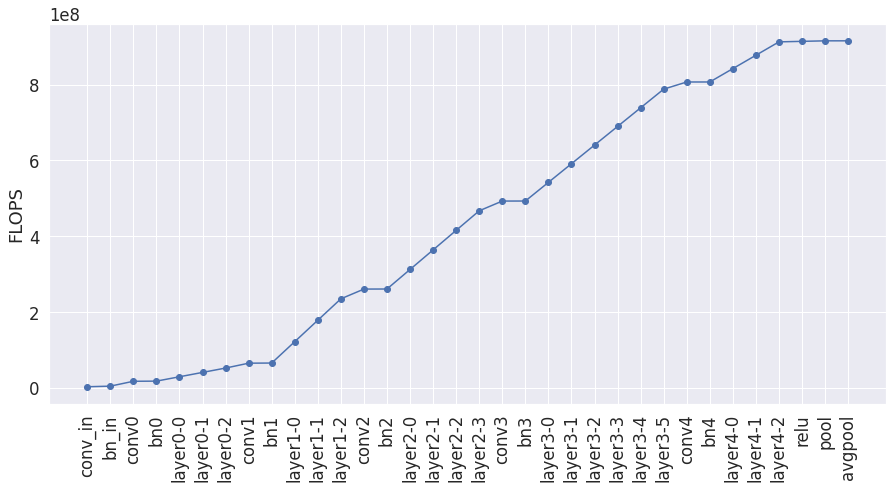

In [19]:
model_cfg = '../configs/model_cfgs/pipeline_simple_san19pair_rgbspec_112.yaml'
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)

model_params.update({
    'num_segments': 1,
    'modality': ['RGB']
})
model = model_factory.generate(model_name, model_factory=model_factory, device=device, **model_params)
model.to(device)

flops, params = get_model_complexity_info(
    model.light_model.rgb, (3, 112, 112), as_strings=False, print_per_layer_stat=False)
flops_dict, params_dict = collect_flops(model.light_model.rgb)

layers_lst, acc_flops_lst, acc_params_lst = [], [], []
for k in flops_dict:
    layers_lst.append(k)
    if len(acc_flops_lst) == 0:
        acc_flops_lst.append(flops_dict[k])
        #acc_params_lst.append(params_dict[k])
    else:
        acc_flops_lst.append(flops_dict[k] + acc_flops_lst[-1])
        #acc_params_lst.append(params_dict[k] + acc_params_lst[-1])

sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(acc_flops_lst, 'o-', label='FLOPS')
ax.set_ylabel('FLOPS')
    
_ = plt.xticks(np.arange(len(layers_lst)), layers_lst, rotation='vertical')
# plt.legend()
# plt.savefig('layer_flops_analysis.pdf', bbox_inches='tight')